<h2> All Calls </h2>

This module will collect additional information and build a feature set to call the W/m^2 model with.  Three seperate calls will be needed and the minutes will be easily engineered.

each call will handle 24 hours worth of data and can be chained to collect larger timeframes.

In [694]:
import requests
import numpy as np
import json
import pandas as pd
import datetime
%store -r

In [695]:
# dictionary form

def clear_cache():
    '''
    optional function to be used to reset the stored data.
    '''
    results = {'Zenith Angle [degrees]': [], 'Azimuth Angle [degrees]': [], 
           'Latitude [deg]': [], 'Longitude [deg]': [], 'Temp [deg C]': [], 
           'Minutes': []}
    return results

results = clear_cache()


In [816]:
#  df form

def clear_cache():
    '''
    optional function to be used to reset the stored data.
    '''
    results = pd.DataFrame(columns = ['Zenith Angle [degrees]', 'Azimuth Angle [degrees]', 'Latitude [deg]',
       'Longitude [deg]', 'Temp [deg C]', 'Minutes', 'Time Index'], index=range(96))
    return results

results = clear_cache()
results.head()

,Zenith Angle [degrees],Azimuth Angle [degrees],Latitude [deg],Longitude [deg],Temp [deg C],Minutes,Time Index
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<h3> Time Helper Functions </h3>

In [697]:
def get_time(user_input = None):
    '''
    gets time in the right formats for our calls
    outputs are in strings
    user_input takes a user input rather than the current time
    
    '''
    if user_input:
        #    will expect a 'sol' format datefield string  mm/dd/yyyy
        units = user_input.split('/')
    else:
        current_time = datetime.datetime.now()
        units = [current_time.year, current_time.month, 
                 current_time.day, current_time.hour, 
                 current_time.minute]
    time_list = []
    for unit in units:
        if unit < 10:
            unit = '0' + str(unit)
        time_list.append(unit)
    return time_list

def convert_time(time_list, sol = True):
    '''
    turns the time_list into the correct format for specific calls
    if sol, format for solortopo.  if not, format for darksky
    returns a string
    '''
    time = (f'{time_list[3]}:{time_list[4]}:00')
    if sol:
        solartopo_date = (f'{time_list[2]-1}/{time_list[1]}/{time_list[0]}')
        return solartopo_date, time
    else:
        darksky_date = (f'{time_list[0]}-{time_list[1]}-{time_list[2]-1}')
        return darksky_date, time
    
def get_next_day(dates):
    '''
    time is relative, add a day.
    accepts sol format
    '''
    split = dates.split('/')
    integers = [int(x) for x in split]
    integers[0] += 1
    string = '/'.join(str(num) for num in integers)
    return string

def convert_minutes(time, forward = False, seconds = True):
    '''
    function takes a military time clock reading eg 14:26 string 
    and converts it to minutes only and vice versa to the seconds 
    '''
    if (forward == False) & (seconds == True):
        minutes = time//60
        seconds = time%60
        hours = minutes//60
        minutes = hours%60
        converted = str(hours) + ':' + str(minutes) + ":" +  str(seconds)
    elif (forward == False) & (seconds == False):
        hours = time//60
        minutes = time%60
        converted = str(hours) + ':' + str(minutes)
    else:
        converted = (int(time.split(':')[0]) * 60) + (int(time.split(':')[1]))
    # missing conditional forward:True seconds:True currently returns the above condition
    return converted

<h3> Minutes </h3>

Create minutes from thin air

In [698]:
def get_minutes(df):
    for i in range(96):
        df.loc[i]['Minutes'] = i*15
#     df.set_index('Minutes')
    return df

# d = df[[p, p.team, p.passing_att, p.passer_rating()] for p in game.players.passing()]

In [817]:
results = get_minutes(results)

In [818]:
results.head()

,Zenith Angle [degrees],Azimuth Angle [degrees],Latitude [deg],Longitude [deg],Temp [deg C],Minutes,Time Index
0,NaN,NaN,NaN,NaN,NaN,0,NaN
1,NaN,NaN,NaN,NaN,NaN,15,NaN
2,NaN,NaN,NaN,NaN,NaN,30,NaN
3,NaN,NaN,NaN,NaN,NaN,45,NaN
4,NaN,NaN,NaN,NaN,NaN,60,NaN


<h3> Geocoder </h3>

Given a zipcode find latitude and longitude.

In [701]:
# string formatting notes - user inputs hardcoded for debugging

location = '10196 west texas place, lakewood co, 80232'
numbers = [int(s) for s in location.split() if s.isdigit()]
# place_name = [str(s) for s in location.split() if not s.isdiget()]
# numbers = map(str, postal_code)
postal_code = str(postal_code[-1])


In [702]:
print(numbers)

[10196, 80232]


In [703]:
def get_coordinates(location, df):
    '''
    gets specific geometric location given a fuzzy address using OpenCage Geocoder.
    accepts a string address
    outputs latitude and longitude
    '''
    from opencage.geocoder import OpenCageGeocode
    
    postal_code = [int(s) for s in location.split() if s.isdigit()]
    # place_name = [str(s) for s in location.split() if not s.isdiget()]
    numbers = str(postal_code)
    
    geocoder = api_keys['open_cage_key'][0]
    geocoder = OpenCageGeocode(geocoder)

    locate = geocoder.geocode(location)
    # returns the following
    # [{'components': {'city': 'Bordeaux',
    #                  'country': 'France',
    #                  'country_code': 'fr',
    #                  'county': 'Bordeaux',
    #                  'house_number': '11',
    #                  'political_union': 'European Union',
    #                  'postcode': '33800',
    #                  'road': 'Rue Sauteyron',
    #                  'state': 'New Aquitaine',
    #                  'suburb': 'Bordeaux Sud'},
    #   'formatted': '11 Rue Sauteyron, 33800 Bordeaux, France',
    #   'geometry': {'lat': 44.8303087, 'lng': -0.5761911}}]

    geometry = locate[0]['geometry']
    lat_long = list(geometry.values())
    lat = lat_long[0]
    long = lat_long[1]
    # appends 1 reading for every hour in the day
    for i in range(96):
#             results['Latitude [deg]'].append(lat)
#             results['Longitude [deg]'].append(long)
            df['Latitude [deg]'] = lat
            df['Longitude [deg]'] = long

In [819]:
get_coordinates(location, results)

In [828]:
results.head()

,Zenith Angle [degrees],Azimuth Angle [degrees],Latitude [deg],Longitude [deg],Temp [deg C],Minutes,Time Index
0,NaN,NaN,39.695883,-105.110853,25.955556,0,1566799200
1,NaN,NaN,39.695883,-105.110853,25.955556,15,1566800100
2,NaN,NaN,39.695883,-105.110853,25.955556,30,NaN
3,NaN,NaN,39.695883,-105.110853,25.955556,45,NaN
4,NaN,NaN,39.695883,-105.110853,26.400000,60,1566802800


<h3> Temp </h3>

Given latitude and longitude find tempurature.

In [706]:
time_list = get_time()
dark, time = convert_time(time_list, sol=False)

In [707]:
print(dark, time)

2019-08-26 12:23:00


In [708]:
def temp_converter(temp, f_to_c=True):
    '''
    helper function
    converts an integer or float to degrees celcius
    or vice verse
    '''
    if f_to_c:
        new_temp = (temp - 32) * 5/9
    else:
        new_temp = (temp * 5/9) + 32
    return new_temp

In [847]:
def get_temp_log_daylight(df):
    darksky = api_keys["darksky_key"][0]
    lat = results['Latitude [deg]'][0]
    long = results['Longitude [deg]'][0]

    darkSky = requests.get(f"https://api.darksky.net/forecast/{darksky}/{lat},{long},{dark}T{time}?exclude=flags,alerts, currently")
    darkSky.status_code == requests.codes.ok
    print(f'{darkSky.status_code == requests.codes.ok}')
    darkSky_call = darkSky.json()
    
    #     darkSky_call['hourly']['data'][0][] = 24 temp readings on the hour every hour and front fill
    for i in range(24):
        temp = (temp_converter(float(darkSky_call['hourly']['data'][i]['temperature'])))
        df['Temp [deg C]'].iloc[lambda x: x.index == i*4] = temp
    df['Temp [deg C]'].ffill(inplace = True)
    
    # using hourly temp data to fill every 15 minute interval
    datetime = darkSky_call['hourly']['data'][0]['time']
    df['Time Index'].iloc[0] = datetime
    for i in range(1,96):
        results['Time Index'].iloc[i] = results['Time Index'].iloc[i-1] + 900

    
    # sunrise and sunset times will be helpful in handling solar data
    
    sunrise = (darkSky_call['daily']['data'][0]['sunriseTime'] -  darkSky_call['hourly']['data'][0]['time'])
    sunrise = convert_minutes(sunrise, forward=False)
    sunset = (darkSky_call['daily']['data'][0]['sunsetTime'] -  darkSky_call['hourly']['data'][0]['time'])
    sunset = convert_minutes(sunset, forward=False)
    
    return sunrise, sunset, df

In [850]:
sunrise, sunset, results = get_temp_log_daylight(results)

True


C:\Users\Mark\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Mark\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Mark\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-

In [851]:
results.head()

,Zenith Angle [degrees],Azimuth Angle [degrees],Latitude [deg],Longitude [deg],Temp [deg C],Time Index
Minutes,,,,,,
0,NaN,NaN,39.695883,-105.110853,25.955556,1566799200
15,NaN,NaN,39.695883,-105.110853,25.955556,1566800100
30,NaN,NaN,39.695883,-105.110853,25.955556,1566801000
45,NaN,NaN,39.695883,-105.110853,25.955556,1566801900
60,NaN,NaN,39.695883,-105.110853,24.438889,1566802800


In [712]:
print("daylight hours:", sunrise, "-", sunset)

daylight hours: 6:6:30 - 19:19:0


<h3> Solar Math </h3>

Given Latitude and Date find Azimuth and Zenith of the sun.
Default date is the day before the current time of the calls

In [713]:
from time import sleep, strftime
from random import randint
import datetime
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup

<h4> Sunpath Hit </h4>

In [714]:
def get_sunpath(driver):
    '''
    helper function that retrieves the sunpath data.
    '''
    zenith = driver.find_element_by_xpath('//*[@id="zenith"]').text
    azimuth = driver.find_element_by_xpath('//*[@id="azimuth"]').text
    if zenith == '' or azimuth == '':
        driver.refresh();
    zenith = float(zenith.split('°')[0])
    azimuth = float(azimuth.split('°')[0])
    print(zenith, azimuth)
    return azimuth, zenith

In [715]:
sol, time = convert_time(time_list, sol=True)
sol

'26/08/2019'

In [839]:
# time_span to be defined by parent function
# Change the date in preperation for the next call 
## will call this outside of function in final so darksky can also update temp/srise sset daily
#         if time_span > 1:
#             sol = get_next_day(date)

def collect_solar_data(df, location=location, date = sol, sunrise = sunrise, sunset = sunset):
    '''
    function takes a time in days, a zipcode, and a date
    and prepares a dictionary of information for as many days as time_span designates
    '''
#     this goes here right now
    df.set_index(['Minutes'], inplace=True)
    
    # init web browser
    Me = "Users/Mark/Downloads"
    chromedriver_path = f'C:/{Me}/chromedriver_win32/chromedriver.exe'
    driver = webdriver.Chrome(executable_path=chromedriver_path)
    sleep(.25)
    
    #  Solar Topo
    solartopo = 'http://solartopo.com'
    orbit = '/solar-orbit.htm'
    daylight = '/daylength.htm'

    date_picker = '//*[@id="datepicker"]'
    address_bar = '//*[@id="address"]'
    submit = '/html/body/div[1]/div[9]/div[1]/input[2]'
    
    # navigate to solartopo.com
    sun_getter = (f'{solartopo}{orbit}')
    driver.get(sun_getter)
    sleep(randint(2,3))
    
    # set local definition for sunrise and sunset as minute integers
    sunrise = convert_minutes(sunrise, forward=True, seconds=True)
    sunset = convert_minutes(sunset, forward=True, seconds=True)
    
    # input location and time
    driver.find_element_by_xpath(f"{date_picker}").clear()
    driver.find_element_by_xpath(f"{date_picker}").send_keys(f'{date}')
    driver.find_element_by_xpath(f"{address_bar}").clear()
    driver.find_element_by_xpath(f"{address_bar}").send_keys(f'{location}')
    driver.find_element_by_xpath(f"{submit}").click()    

    # Trun the clock back in order to get chronologic readings
    display_time = driver.find_element_by_xpath('//*[@id="time"]').text
    slider = driver.find_element_by_xpath('//*[@id="slider-range-min"]/a')
    while convert_minutes(display_time, forward=True, seconds=False) > sunrise:
        print(display_time)
        display_time = driver.find_element_by_xpath('//*[@id="time"]').text
        slider.send_keys(Keys.ARROW_LEFT + Keys.ARROW_LEFT + Keys.ARROW_LEFT + Keys.ARROW_LEFT + Keys.ARROW_LEFT
                        + Keys.ARROW_LEFT + Keys.ARROW_LEFT + Keys.ARROW_LEFT + Keys.ARROW_LEFT + Keys.ARROW_LEFT)
        
    # Collect readings for daylight hours
    # hard coded for 15 minute intervals 24 * 4 = 96 are the max intervals in one day
    for i in range(96):
        slider.send_keys(Keys.ARROW_RIGHT + Keys.ARROW_RIGHT + Keys.ARROW_RIGHT + Keys.ARROW_RIGHT + Keys.ARROW_RIGHT
                    + Keys.ARROW_RIGHT + Keys.ARROW_RIGHT + Keys.ARROW_RIGHT + Keys.ARROW_RIGHT + Keys.ARROW_RIGHT
                        + Keys.ARROW_RIGHT + Keys.ARROW_RIGHT + Keys.ARROW_RIGHT + Keys.ARROW_RIGHT + Keys.ARROW_RIGHT)
        display_time = driver.find_element_by_xpath('//*[@id="time"]').text
        minute = convert_minutes(display_time, forward=True, seconds=False)
        if minute < sunrise:
            pass
        elif minute > sunset:
            break
        else:
            # scrape zenith / azimuth
            zenith, azimuth = get_sunpath(driver)
            iloc = results.index.get_loc(minute, method='bfill')
            df['Zenith Angle [degrees]'].iloc[iloc] = zenith
            df['Azimuth Angle [degrees]'].iloc[iloc] = azimuth
                
    return

In [840]:
collect_solar_data(results)

12:00
12:00
11:50
11:40
11:30
11:20
11:10
11:00
10:50
10:40
10:30
10:20
10:10
10:00
09:50
09:40
09:30
09:20
09:10
09:00
08:50
08:40
08:30
08:20
08:10
08:00
07:50
07:40
07:30
07:20
07:10
07:00
06:50
06:40
06:30
06:20
06:10
-1.06 75.24
1.83 77.65
4.52 80.02
7.26 82.38
10.1 84.74
12.95 87.1
15.82 89.48
18.69 91.89
21.56 94.36
24.42 96.88
27.26 99.49
30.09 102.18
32.89 105.02
35.65 107.97
38.36 111.12
41.02 114.43
43.59 118.04
46.09 121.84
48.47 126.04
50.74 130.5
52.82 135.48
54.76 140.75
56.43 146.63
57.92 152.8
59.03 159.58
59.91 166.56
60.34 173.95
60.51 181.36
60.19 188.79
59.64 196.04
58.61 202.93
57.4 209.52
55.8 215.53
54.05 221.24
52.02 226.33
49.88 231.15
47.55 235.45
45.14 239.55
42.59 243.22
39.99 246.75
37.3 249.96
34.57 253.06
31.79 255.93
28.98 258.73
26.14 261.37
23.28 263.95
20.41 266.43
17.54 268.88
14.66 271.27
11.79 273.65
8.95 276.0
6.13 278.35


In [846]:
results.loc[360:420]

,Zenith Angle [degrees],Azimuth Angle [degrees],Latitude [deg],Longitude [deg],Temp [deg C],Time Index
Minutes,,,,,,
360,NaN,NaN,39.695883,-105.110853,15.577778,1566820800
375,NaN,NaN,39.695883,-105.110853,15.577778,NaN
390,75.24,-1.06,39.695883,-105.110853,15.577778,NaN
405,77.65,1.83,39.695883,-105.110853,15.577778,NaN
420,80.02,4.52,39.695883,-105.110853,15.172222,1566824400


In [885]:
copy = results.copy()

In [866]:
copy.head()

,Zenith Angle [degrees],Azimuth Angle [degrees],Latitude [deg],Longitude [deg],Temp [deg C],Time Index
Minutes,,,,,,
0,NaN,NaN,39.695883,-105.110853,25.955556,1566799200
15,NaN,NaN,39.695883,-105.110853,25.955556,1566800100
30,NaN,NaN,39.695883,-105.110853,25.955556,1566801000
45,NaN,NaN,39.695883,-105.110853,25.955556,1566801900
60,NaN,NaN,39.695883,-105.110853,24.438889,1566802800


In [867]:
copy.columns

Index(['Zenith Angle [degrees]', 'Azimuth Angle [degrees]', 'Latitude [deg]',
       'Longitude [deg]', 'Temp [deg C]', 'Time Index'],
      dtype='object')

<h3> Cleaning Data </h3>

To save trouble, eliminate room for error, and pad our visual with easy and accurate predictions.  We want to set all values before sunrise and after sunset to zeros.  This will signal the model to output a huge negative W/m^2 output which is just fine because when it comes time to plot we can translate any negative values to zero.

In [886]:
def cleaning(df, timezone = 6):
        
    sunrise_minutes = convert_minutes(sunrise, forward=True, seconds=True)
    sunset_minutes = convert_minutes(sunset, forward=True, seconds=True)

    df.loc[0:sunrise_minutes+15, ['Zenith Angle [degrees]', 'Azimuth Angle [degrees]', 'Latitude [deg]',
       'Longitude [deg]', 'Temp [deg C]']] = 0 # because we chose to back fill the solar data we have one na reading after sunsrise = 
    df.loc[sunset_minutes:0, ['Zenith Angle [degrees]', 'Azimuth Angle [degrees]', 'Latitude [deg]',
       'Longitude [deg]', 'Temp [deg C]']] = 0
    
    df['Time Index'] = pd.to_datetime(df['Time Index'], unit='s')
    # time is four hours ahead because of timezone +6 GMT
    df['Time Index'] = df['Time Index'] - pd.Timedelta(hours = timezone)
    final = df.set_index(pd.DatetimeIndex(df['Time Index']), append=True)
    final.reset_index(level=0, inplace=True)


    return final

In [887]:
results_2 = cleaning(copy)

In [888]:
results_2.head()

,Minutes,Zenith Angle [degrees],Azimuth Angle [degrees],Latitude [deg],Longitude [deg],Temp [deg C],Time Index
Time Index,,,,,,,
2019-08-26 00:00:00,0,0,0,0.0,0.0,0.0,2019-08-26 00:00:00
2019-08-26 00:15:00,15,0,0,0.0,0.0,0.0,2019-08-26 00:15:00
2019-08-26 00:30:00,30,0,0,0.0,0.0,0.0,2019-08-26 00:30:00
2019-08-26 00:45:00,45,0,0,0.0,0.0,0.0,2019-08-26 00:45:00
2019-08-26 01:00:00,60,0,0,0.0,0.0,0.0,2019-08-26 01:00:00


In [889]:
results_2['Minutes Final'] = results_2['Minutes']

In [890]:
results_2.drop(['Minutes', 'Time Index'], axis = 1, inplace = True)

In [891]:
results_2.head()

,Zenith Angle [degrees],Azimuth Angle [degrees],Latitude [deg],Longitude [deg],Temp [deg C],Minutes Final
Time Index,,,,,,
2019-08-26 00:00:00,0,0,0.0,0.0,0.0,0
2019-08-26 00:15:00,0,0,0.0,0.0,0.0,15
2019-08-26 00:30:00,0,0,0.0,0.0,0.0,30
2019-08-26 00:45:00,0,0,0.0,0.0,0.0,45
2019-08-26 01:00:00,0,0,0.0,0.0,0.0,60


<h2> Send Cached Data <h2>

In [ ]:
# if minutes converted to pandas datetime series can set conditionals for plot
# midnight to sunrise fill df.loc[midnight:sunrise] = 0

In [ ]:
# launch on heroku

<h2> Test Cached Data Using Trained Ensemble Model </h2>

In [319]:
import os
cwd = os.getcwd()
cwd

'C:\\Users\\Mark\\Documents\\DataSci\\Module 3\\Peer2Peer'

In [765]:
import pickle
loaded_model = pickle.load(open('C:\\Users\\Mark\\Documents\\DataSci\\Module 5\\finalized_model.pkl', 'rb'))
loaded_scaler = pickle.load(open('C:\\Users\\Mark\\Documents\\DataSci\\Module 5\\scaler.pkl', 'rb'))

features2 = loaded_scaler.transform(results_2)
output2 = loaded_model.predict(features)
output2 = output2.clip(min=0)

[12:45:05] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


sklearn.model_selection._search.GridSearchCV

In [901]:
output2

array([  0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
         0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
         0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
         0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
         0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
         0.       , 135.03836  , 118.347145 ,  63.522198 ,  53.465206 ,
        42.164394 ,  15.849642 ,   1.9054433,   0.       ,   0.       ,
         0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
         0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
         0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
         0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
         0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
         0.       ,   0.       ,   0.       ,   0.       ,   6.2453365,
         6.2453365,   6.2453365,   0.       ,   0.       ,   0. 

In [762]:
import matplotlib.pyplot as plt

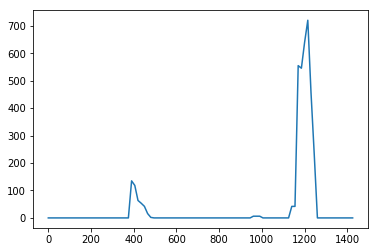

In [902]:
x = np.array(range(len(output)))
x = x*15
plt.plot(x, output2);

In [910]:
import pickle
loaded_ss_model = pickle.load(open('C:\\Users\\Mark\\Documents\\DataSci\\Module 5\\ss_model.pkl', 'rb'))
loaded_ss_scaler = pickle.load(open('C:\\Users\\Mark\\Documents\\DataSci\\Module 5\\ss_scaler.pkl', 'rb'))

features2 = loaded_ss_scaler.transform(results_2)
output3 = loaded_ss_model.predict(features2)
output3 = output2.clip(min=0)

[09:28:45] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [911]:
output3

array([  0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
         0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
         0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
         0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
         0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
         0.       , 135.03836  , 118.347145 ,  63.522198 ,  53.465206 ,
        42.164394 ,  15.849642 ,   1.9054433,   0.       ,   0.       ,
         0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
         0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
         0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
         0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
         0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
         0.       ,   0.       ,   0.       ,   0.       ,   6.2453365,
         6.2453365,   6.2453365,   0.       ,   0.       ,   0. 

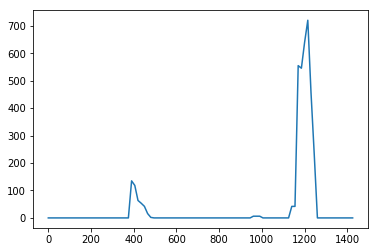

In [912]:
x = np.array(range(len(output3)))
x = x*15
plt.plot(x, output3);